<a href="https://colab.research.google.com/github/joshbrx/biomath_model/blob/main/healthy_GRN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRN model for stellate cells in pancreas.

Para modelar correctamente la red de regulación genética, renormbraremos las variables del sistema para poder simplificar el proceso

| $TNF_a$ | $TGFb_1$ | $RAS$ | $P53$ | $PIP3$ | $ERK$ | Apoptosis | Proliferation |
|:-------:|:--------:|:-----:|:-----:|:------:|:-----:|:-----------:|:---------------:|
|  $X_1$  |   $X_2$  | $Y_1$ | $Y_2$ |  $Y_3$ | $Y_4$ |    $Z_1$    |      $Z_2$      |

In [650]:
import matplotlib.pyplot as plt
import numpy as np
import random 

In [651]:
def supr(e, n, s):
    return e/(1 + s**n)

In [718]:
def dS(S, i, y1_tau1):
    y1, y2, y3, y4, z1, z2, Ry1, Ry2, Ry3, Ry4, Rz1, Rz2 = S
    # --------------------------------------------------------
    dRy1 = e[0]*(supr(1, n[0], X1[i]) + supr(1, n[0], y1_tau1) + supr(1, n[0], y3) + supr(1, n[0], y4)) - Ry1;    
    dy1  = supr(1, n[1], Ry1) - y1;         # 1/0.4

    # dRy2 = e[1]*(supr(1, n[0], y1) + supr(1, -n[0], y2) + supr(1, -n[0], y3)) - Ry2
    dRy2 = e[1]*(supr(1, n[0], y1) + (supr(1, -n[0], y2) * supr(1, -n[0], y3))) - Ry2
    dy2  = supr(1, n[1], Ry2) - y2;         # 1/2.14 o 1/2.1

    dRy3 = e[2]*(supr(1, n[0], X2[i]) + supr(1, n[0], y1) + supr(1, -n[0], y2)) - Ry3         
    dy3  = supr(1, n[1], Ry3) - y3;         # 1/2.14

    dRy4 = e[3]*(supr(1, n[0], X2[i]) + supr(1, n[0], y1)) - Ry4;
    dy4  = supr(1, n[1], Ry4) - y4;         # 1/0.35
    # --------------------------------------------------------
    # dRz1 = dRy2; dz1  = dy2;
    dRz2 = e[4]*(supr(1, -n[0], y2) + supr(1, n[0], y4)) - Rz2
    dz2  = supr(1, n[1], Rz2) - z2;         # 1/1.15
    # --------------------------------------------------------
    dS = [dy1, dy2, dy3, dy4, dy2, dz2, dRy1, dRy2, dRy3, dRy4, dRy2, dRz2]
    return np.array(dS)

In [719]:
def RK_solver(S0, t, k):
    dims = len(S0)
    K = np.empty([4, dims])
    S = np.zeros([len(t)+1, dims])
    
    for d in range(dims):   
        S[0, d] = S0[d]

    dt = t[1] - t[0]; 
    for i in range(len(t)):
        y1_tau = S[i-k, 0]
        K[0] = dt * dS(S[i]         , i, y1_tau) 
        K[1] = dt * dS(S[i] + K[0]/2, i, y1_tau)
        K[2] = dt * dS(S[i] + K[1]/2, i, y1_tau)
        K[3] = dt * dS(S[i] + K[2]  , i, y1_tau)
        for d in range(dims):
            S[i+1, d] = S[i, d] + (K[0,d]+2*K[1,d]+2*K[2,d]+K[3,d])/6
    return S

In [720]:
# parámetros
n = [-4, -20] 
e = [1/0.4, 1/1.2, 1/2.14, 1/0.35, 1/1.15]
start=0; step=0.1; num=5000
t = np.arange(0,num)*step + start

<ipython-input-709-c9dcc9093113>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return e/(1 + s**n)


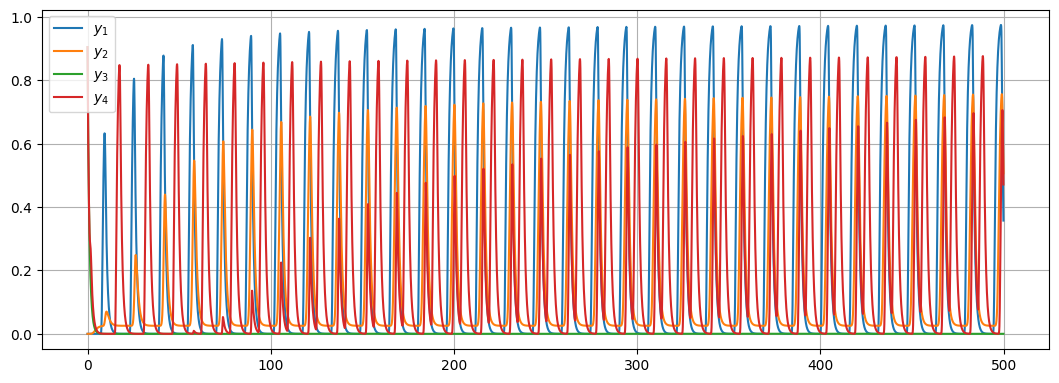

In [721]:
S0 = np.concatenate([np.array([0, 0, 1, 1]), np.zeros(2), np.zeros(6)])   # R, Y, Z
A = np.array([1,1,1,1]);
omega = 1/5.0; X1, X2 = np.sin(t*omega)**4, np.cos(t*omega)**4           # omega_max = 7.715
# X1, X2 = np.ones(num), np.ones(num)       
labels = ["$y_1$","$y_2$","$y_3$","$y_4$","$s_2$","$s_3$","$s_4$","$s_5$","$z_1$","$z_2$","$z_3$","$z_4$"]

Pip = RK_solver(S0, t, 150)
plt.figure(figsize=(13,4.5), dpi=100)
for i in range(4):
    plt.plot(t, Pip[1:,i], label=labels[i])
plt.legend(); plt.grid(); plt.show()

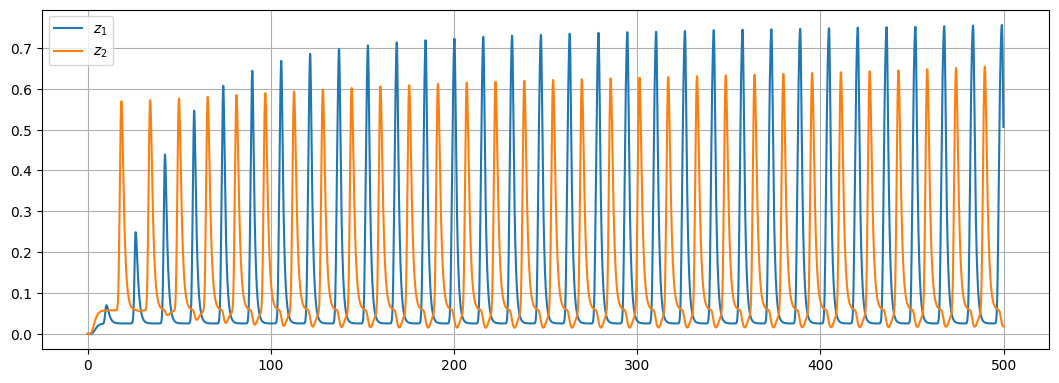

0.14121411745222184 0.1459458251974391


In [722]:
plt.figure(figsize=(13,4.5), dpi=100)
for i in range(2):
    plt.plot(t, Pip[1:,i+4]*A[i], label=labels[i+8])
plt.legend(); plt.grid(); plt.show()
print(np.mean(Pip[1:,4]), np.mean(Pip[1:,5]))

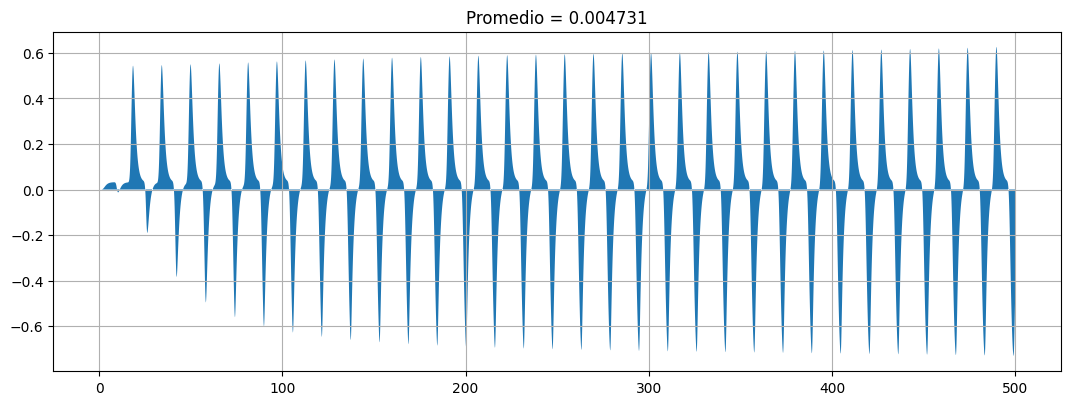

In [724]:
plt.figure(figsize=(13,4.5), dpi=100)

# plt.plot(-Pip[:,8] + Pip[:,9] - Pip[:,10] + Pip[:,11])
# plt.plot(t, -A[0]*Pip[1:,8] + A[1]*Pip[1:,9], "r")
plt.fill_between(t, -A[0]*Pip[1:,4] + A[1]*Pip[1:,5])
plt.grid(); plt.title(f"Promedio = {round(np.mean(-A[0]*Pip[:,4] + A[1]*Pip[:,5]), 6)}"); plt.show()

In [658]:
Pip[-1,:]

array([9.99999999e-01, 7.43777393e-01, 6.92004626e-05, 9.99752998e-01,
       7.43777393e-01, 8.70734332e-01, 2.66921128e+00, 1.05472995e+00,
       6.44028206e-01, 1.75012693e+00, 1.05472995e+00, 1.10017574e+00])